In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [2]:
import cudf as cupd
from cuml.neighbors import KNeighborsClassifier
from cuml.svm import SVC as cuSVC, LinearSVC as cuLinearSVC
from cuml import RandomForestClassifier as cuRandomForestClassifier
from cuml.model_selection import train_test_split as cuTrainTestSplit

## CALCULATE METRICS

In [3]:
def getConfusionMatrix(labels: np.ndarray, predictions: np.ndarray):
    confusion = dict()
    confusion["TP"] = np.sum(labels & predictions)
    confusion["TN"] = np.sum(~labels & ~predictions)
    confusion["FP"] = np.sum(~labels & predictions)
    confusion["FN"] = np.sum(labels & ~predictions)
    return confusion

def getMetrics(confusion):
    metrics = dict()
    metrics["accuracy"] = (confusion["TP"] + confusion["TN"]) / (confusion["TP"] + confusion["TN"] + confusion["FP"] + confusion["FN"])
    metrics["precision"] = confusion["TP"] / (confusion["TP"] + confusion["FP"])
    metrics["recall"] = confusion["TP"] / (confusion["TP"] + confusion["FN"])
    metrics["f1"] = 2 * (metrics["precision"] * metrics["recall"]) / (metrics["precision"] + metrics["recall"])
    return metrics

def printMetrics(confusion):
    print("Accuracy: \t", confusion["accuracy"])
    print("Precision: \t", confusion["precision"])
    print("Recall: \t", confusion["recall"])
    print("F1: \t\t", confusion["f1"])
    
def printAll(confusionTrain, confusionTest):
    print("Accuracy: \t", confusionTrain["accuracy"], "\tAccuracy: \t", confusionTest["accuracy"])
    print("Precision: \t", confusionTrain["precision"], "\tPrecision: \t", confusionTest["precision"])
    print("Recall: \t", confusionTrain["recall"], "\tRecall: \t", confusionTest["recall"])
    print("F1: \t\t", confusionTrain["f1"], "\tF1: \t\t", confusionTest["f1"])

## Load Data CPU

In [5]:
covid = pd.read_parquet('covidClean.parquet')

toRemove = ["PATIENT_ID", "USMER", "SYMPTOMS_DATE",
            "MEDICAL_UNIT", "ADMISSION_DATE", "PATIENT_TYPE",
            "DEATH_DATE", "ORIGIN_COUNTRY", "DAYS"]
covid = covid.drop(columns = toRemove)
covid = covid.drop(columns= ["DIED", "INTUBED", "ICU"])

In [6]:
labels = covid.AT_RISK
covid = covid.drop(columns= ["AT_RISK"])

trainingX, testX, trainingY, testY = train_test_split(covid, labels, test_size=0.25)

## Load Data GPU

In [4]:
cuCovid = cupd.read_parquet('covidClean.parquet')

toRemove = ["PATIENT_ID", "USMER", "SYMPTOMS_DATE",
        "MEDICAL_UNIT", "ADMISSION_DATE", "PATIENT_TYPE",
        "DEATH_DATE", "ORIGIN_COUNTRY", "DAYS"]
cuCovid = cuCovid.drop(columns = toRemove)
cuCovid = cuCovid.drop(columns= ["DIED", "INTUBED", "ICU"])
cuCovid = cuCovid.astype('float32')

In [5]:
labels = cuCovid.AT_RISK
covidX = cuCovid.drop(columns = ["AT_RISK"])

cuTrainingX, cuTestX, cuTrainingY, cuTestY = cuTrainTestSplit(covidX, labels, test_size=0.25)

cuTestY = cuTestY.to_pandas().to_numpy().astype("bool")
cuTrainY = cuTrainingY.to_pandas().to_numpy().astype("bool")

In [6]:
def convertToNumpy(df):
    return df.to_pandas().to_numpy().astype("bool")

## RANDOM FOREST

In [18]:
metric = "recall"
depths = range(3, 20, 2)
heuristics = ["entropy", "gini"]
results = {
    "entropy": dict(),
    "gini": dict()
}

for heuristic in heuristics:
    print("Heuristic:", heuristic)
    for depth in depths:
        print("Depth:", depth)
        rf = cuRandomForestClassifier(n_estimators=100, max_depth=depth, split_criterion=heuristic)
        rf.fit(cuTrainingX, cuTrainingY)

        predictionsTest = rf.predict(cuTestX)
        predictionsTest = convertToNumpy(predictionsTest)
        metricsTest = getMetrics(getConfusionMatrix(cuTestY, predictionsTest))
        results[heuristic][depth] = metricsTest[metric]
        if(depth > 3 and results[heuristic][depth - 2] > metricsTest[metric]):
            break

Heuristic: entropy
Depth: 3
Depth: 5
Heuristic: gini
Depth: 3
Depth: 5
Depth: 7
Depth: 9
Depth: 11


In [19]:
for (heuristic, values) in results.items():
    print("Heuristic:", heuristic)
    for (depth, m) in values.items():
        print("Depth:", depth, "\t", metric, ":", m)

Heuristic: entropy
Depth: 3 	 recall : 0.6556960664417896
Depth: 5 	 recall : 0.6551316337638252
Heuristic: gini
Depth: 3 	 recall : 0.6530217306581017
Depth: 5 	 recall : 0.6563545712327479
Depth: 7 	 recall : 0.685449731894478
Depth: 9 	 recall : 0.6893738828936582
Depth: 11 	 recall : 0.6889438389485426


In [20]:
bestDepthEntropy = max(results["entropy"], key=results["entropy"].get)
bestDepthGini = max(results["gini"], key=results["gini"].get)

print("Gini: ", bestDepthGini)
print("Entropy: ", bestDepthEntropy)

Gini:  9
Entropy:  3


In [22]:
for heuristic in heuristics:
    rf = cuRandomForestClassifier(n_estimators=100, 
                                max_depth=max(results[heuristic], key=results[heuristic].get), 
                                split_criterion=heuristic)
    rf.fit(cuTrainingX, cuTrainingY)

    predictionsTrain = rf.predict(cuTrainingX)
    predictionsTest = rf.predict(cuTestX)

    predictionsTrain = convertToNumpy(predictionsTrain)
    predictionsTest = convertToNumpy(predictionsTest)

    metricsTest = getMetrics(getConfusionMatrix(cuTestY, predictionsTest))
    metricsTrain = getMetrics(getConfusionMatrix(cuTrainY, predictionsTrain))

    print("\nRF '" + heuristic + "' (GPU) on Training Set: \tRF '" + heuristic + "' (GPU) on Test Set:")
    printAll(metricsTrain, metricsTest)


RF 'entropy' (GPU) on Training Set: 	RF 'entropy' (GPU) on Test Set:
Accuracy: 	 0.6339004805359463 	Accuracy: 	 0.6354708222366824
Precision: 	 0.6272292002147075 	Precision: 	 0.6294719459173537
Recall: 	 0.6550632343707956 	Recall: 	 0.6556960664417896
F1: 		 0.6408441280670389 	F1: 		 0.6423164518634563

RF 'gini' (GPU) on Training Set: 	RF 'gini' (GPU) on Test Set:
Accuracy: 	 0.6433837422771008 	Accuracy: 	 0.6420650839544104
Precision: 	 0.629434546862897 	Precision: 	 0.6291022810890361
Recall: 	 0.6924118755045295 	Recall: 	 0.6893738828936582
F1: 		 0.65942298246738 	F1: 		 0.6578604818180069


## NAIVE BAYES GAUSSIAN

In [6]:
nb = GaussianNB()
nb.fit(trainingX, trainingY)

predictionsTrain = nb.predict(trainingX)
predictionsTest = nb.predict(testX)

metricsTest = getMetrics(getConfusionMatrix(testY, predictionsTest))
metricsTraing = getMetrics(getConfusionMatrix(trainingY, predictionsTrain))

print("\nNB Gaussian on Training Set: \t\tNB Gaussian on Test Set:")
printAll(metricsTraing, metricsTest)


NB Gaussian on Training Set: 		NB Gaussian on Test Set:
Accuracy: 	 0.6269968336881272 	Accuracy: 	 0.62692023881398
Precision: 	 0.6015250072275224 	Precision: 	 0.6016939973571909
Recall: 	 0.7464371877774688 	Recall: 	 0.7467369241729732
F1: 		 0.6661917321369253 	F1: 		 0.6664147457698283


## NAIVE BAYES MULTINOMIAL

In [8]:
trainXCategorial = trainingX.copy()
trainXCategorial.AGE = trainingX.AGE >= trainingX.AGE.median()

nb = MultinomialNB()
nb.fit(trainXCategorial, trainingY)

predictionsTrain = nb.predict(trainXCategorial)
predictionTest = nb.predict(testX)

metricsTest = getMetrics(getConfusionMatrix(testY, predictionTest))
metricsTrainig = getMetrics(getConfusionMatrix(trainingY, predictionsTrain))

print("\nNB Multinomial on Training Set: \tNB Multinomial on Test Set:")
printAll(metricsTrainig, metricsTest)


NB Multinomial on Training Set: 	NB Multinomial on Test Set:
Accuracy: 	 0.5845982182787428 	Accuracy: 	 0.5010531964848729
Precision: 	 0.5792350424621672 	Precision: 	 0.5000505121936435
Recall: 	 0.6101893290522785 	Recall: 	 0.998037449760058
F1: 		 0.5943093993837257 	F1: 		 0.6662748124484008


In [14]:
from sklearn.naive_bayes import BernoulliNB
from weightedstats import numpy_weighted_median

trainXCategorial = trainingX.copy()
trainXCategorial.AGE = trainingX.AGE >= trainingX.AGE.median() #numpy_weighted_median(trainingX.AGE.to_numpy(), trainingX.AGE.value_counts())

nb = BernoulliNB()
nb.fit(trainXCategorial, trainingY)

predictionsTrain = nb.predict(trainXCategorial)
predictionTest = nb.predict(testX)

metricsTest = getMetrics(getConfusionMatrix(testY, predictionTest))
metricsTrainig = getMetrics(getConfusionMatrix(trainingY, predictionsTrain))

print("\nNB Multinomial on Training Set: \tNB Multinomial on Test Set:")
printAll(metricsTrainig, metricsTest)


NB Multinomial on Training Set: 	NB Multinomial on Test Set:
Accuracy: 	 0.6330253483837498 	Accuracy: 	 0.5843965922050044
Precision: 	 0.6311524315852279 	Precision: 	 0.5535112299004181
Recall: 	 0.6355728531458498 	Recall: 	 0.8632726881546923
F1: 		 0.6333549295145326 	F1: 		 0.6745292930991006


## KNN - K NEAREST NEIGHBORS

In [6]:
def findBestK(lower, upper, res: dict, metric="accuracy"):
    median = (lower + upper) // 2
    if lower == median:
        return lower
    
    results = dict()
    print("K: L -> " + str(lower) + " \t/ M -> " + str(median) + "\t/  U ->" + str(upper))
    for k in [lower, median, upper]:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(cuTrainingX, cuTrainingY)
        predicted = knn.predict(cuTestX)
        
        predicted = convertToNumpy(predicted)
        results[k] = getMetrics(getConfusionMatrix(cuTestY, predicted))[metric]
        res[k] = results[k]

    if results[median] > results[lower]:
        return findBestK(median, upper, res, metric)
    else:
        return findBestK(lower, median, res, metric)

In [7]:
metric = "recall"
results = {}
bestK = findBestK(1, 750, results, metric)
print("Best K: ", bestK)

K: L -> 1 	/ M -> 375	/  U ->750
K: L -> 375 	/ M -> 562	/  U ->750
K: L -> 375 	/ M -> 468	/  U ->562
K: L -> 468 	/ M -> 515	/  U ->562
K: L -> 468 	/ M -> 491	/  U ->515
K: L -> 468 	/ M -> 479	/  U ->491
K: L -> 468 	/ M -> 473	/  U ->479
K: L -> 473 	/ M -> 476	/  U ->479
K: L -> 473 	/ M -> 474	/  U ->476
Best K:  473


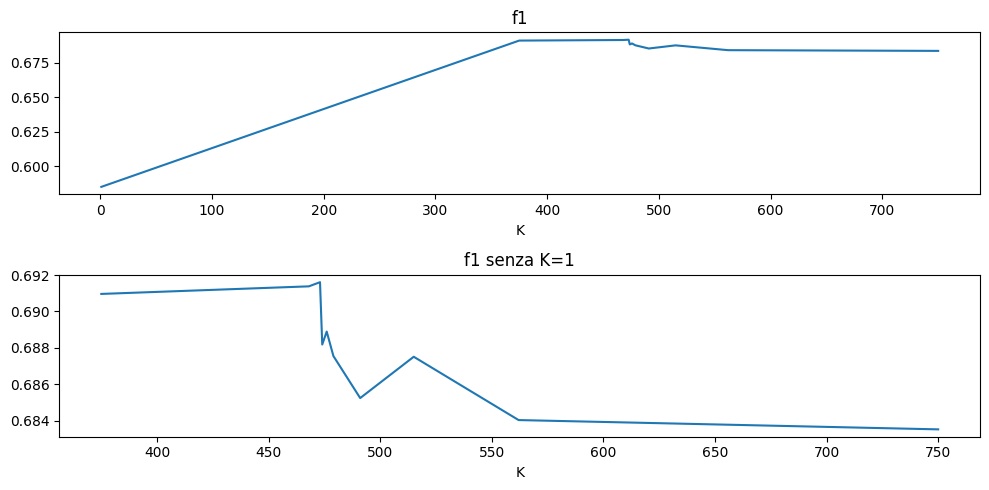

In [8]:
res = sorted(results.items())

x = [k for (k, _) in res]
y = [v for (_, v) in res]
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(x, y);
plt.title(metric)
plt.xlabel("K")
plt.subplot(2, 1, 2)
plt.title(metric + " senza K=1")
plt.xlabel("K")
plt.plot(x[1:], y[1:]);
plt.tight_layout()

In [12]:
knn = KNeighborsClassifier(n_neighbors=bestK)
knn.fit(cuTrainingX, cuTrainingY)

predictedTrain = knn.predict(cuTrainingX)
predictedTest = knn.predict(cuTestX)

predictedTrain = convertToNumpy(predictedTrain)
predictedTest = convertToNumpy(predictedTest)

metricsTrain = getMetrics(getConfusionMatrix(cuTrainY, predictedTrain))
metricsTest = getMetrics(getConfusionMatrix(cuTestY, predictedTest))

print("\nKNN on Training Set: \t\t\tKNN on Test Set: " )
printAll(metricsTrain, metricsTest)


KNN on Training Set: 			KNN on Test Set: 
Accuracy: 	 0.6438085995585956 	Accuracy: 	 0.6451441949701145
Precision: 	 0.6299283300409776 	Precision: 	 0.6322324707385073
Recall: 	 0.6922317904556872 	Recall: 	 0.6916069917104433
F1: 		 0.6596121135452548 	F1: 		 0.660588250391397


## LINEAR SVM

In [ ]:
svm = cuLinearSVC(max_iter=100000)
svm.fit(cuTrainingX, cuTrainingY)

predictionsTrain = svm.predict(cuTrainingX)
predictionsTest = svm.predict(cuTestX)

predictionsTrain = convertToNumpy(predictionsTrain)
predictionsTest = convertToNumpy(predictionsTest)

metricsTrain = getMetrics(getConfusionMatrix(cuTrainY, predictionsTrain))
metricsTest = getMetrics(getConfusionMatrix(cuTestY, predictionsTest))

print("\nLinear SVM (GPU) on Training Set: \tLinear SVM (GPU) on Test Set:")
printAll(metricsTrain, metricsTest)

## SVM

In [8]:
results = dict()
kernels = ["rbf", "sigmoid"]

for kernel in kernels:
    svm = cuSVC(kernel=kernel, max_iter=10000, degree=8)
    svm.fit(cuTrainingX, cuTrainingY)

    predictionsTrain = svm.predict(cuTrainingX)
    predictionsTest = svm.predict(cuTestX)
    
    predictionsTrain = convertToNumpy(predictionsTrain)
    predictionsTest = convertToNumpy(predictionsTest)

    metricsTrain = getMetrics(getConfusionMatrix(cuTrainY, predictionsTrain))
    metricsTest = getMetrics(getConfusionMatrix(cuTestY, predictionsTest))
    
    print("\nSVM con kernel '" + kernel + "' on Training Set: \t\tSVM con kernel '" + kernel + "' on Test Set:")
    printAll(metricsTrain, metricsTest)


SVM con kernel 'rbf' on Training Set: 		SVM con kernel 'rbf' on Test Set:
Accuracy: 	 0.6406646556755342 	Accuracy: 	 0.6393415129906285
Precision: 	 0.6206748326085189 	Precision: 	 0.6200272590659692
Recall: 	 0.7186542971289699 	Recall: 	 0.7156783649320962
F1: 		 0.6660806902054658 	F1: 		 0.6644279802512904

SVM con kernel 'sigmoid' on Training Set: 		SVM con kernel 'sigmoid' on Test Set:
Accuracy: 	 0.4143521261870848 	Accuracy: 	 0.41579402826878825
Precision: 	 0.41246465810657496 	Precision: 	 0.4144753655157572
Recall: 	 0.4107909120665767 	Recall: 	 0.41434718300389944
F1: 		 0.41162608365514436 	F1: 		 0.41441126434772085


## LOGISTIC REGRESSION

In [6]:
totalMetrics = dict()
solvers = ["lbfgs", "liblinear", "newton-cg", "sag"]

for solver in solvers:
    lr = LogisticRegression(max_iter=100000, solver=solver)
    lr.fit(trainingX, trainingY)
    
    predictionsTrain = lr.predict(trainingX)
    predictionsTest = lr.predict(testX)

    metricsTest = getMetrics(getConfusionMatrix(testY, predictionsTest))
    metricsTrain = getMetrics(getConfusionMatrix(trainingY, predictionsTrain))
    
    totalMetrics[solver] = (metricsTrain, metricsTest)

    print("\nLogistic Regression (solver = \"" + solver + "\") on Training Set: \t\t Logistic Regression (solver = \"" + solver + "\") on Test Set:")
    printAll(metricsTrain, metricsTest)


Logistic Regression (solver = "lbfgs") on Training Set: 		 Logistic Regression (solver = "lbfgs") on Test Set:
Accuracy: 	 0.6432711400511619 	Accuracy: 	 0.6444757496478165
Precision: 	 0.6344466572797348 	Precision: 	 0.6350795183171587
Recall: 	 0.6724750700280112 	Recall: 	 0.6732017343064121
F1: 		 0.6529075940333838 	F1: 		 0.6535852016471665

Logistic Regression (solver = "liblinear") on Training Set: 		 Logistic Regression (solver = "liblinear") on Test Set:
Accuracy: 	 0.6433695282731973 	Accuracy: 	 0.6444824579056819
Precision: 	 0.6346524136588504 	Precision: 	 0.6351700031776295
Recall: 	 0.6721299719887955 	Recall: 	 0.6728785716209301
F1: 		 0.6528537784104513 	F1: 		 0.6534807540162545

Logistic Regression (solver = "newton-cg") on Training Set: 		 Logistic Regression (solver = "newton-cg") on Test Set:
Accuracy: 	 0.64338741704084 	Accuracy: 	 0.6445361239686054
Precision: 	 0.6346602233440675 	Precision: 	 0.6352105336739492
Recall: 	 0.6721837535014006 	Recall: 	 0.